# Kaggle Data Analysis - Suicide Rate Study
### Author: Pau Blasco Roca
### NIU: 1600959


The objective of our study is to analyze the relationships between suicides and other socioeconomic factors accross different countries in Europe (continent). To keep the study in a reasonable scope, we'll study the 10 most populated regions in Europe.

We will start by importing all necessary libraries.

In [394]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We will also import our own methods and files, that will help us along the way.

In [395]:
from ingest_data import ingest
from clean_data import where_selection, lin_normalize, class_normalize
from generate_features import corr_feature_selection, lasso_feature_selection

## Data reading
To read our data (stored in the data folder) we can simply call our ingest function, and store the output in a dataframe type variable.

In [396]:
raw = ingest("../data/master.csv")

## Data Exploration
In this section we will simply investigate and visualize some relationships in our raw datasets. This, hopefully , will give us some ideas on what variables to prioritize or target later on.

Let us first see how a small sample of the table looks like.

In [397]:
raw.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


We can start by observing the evolution of the data along time

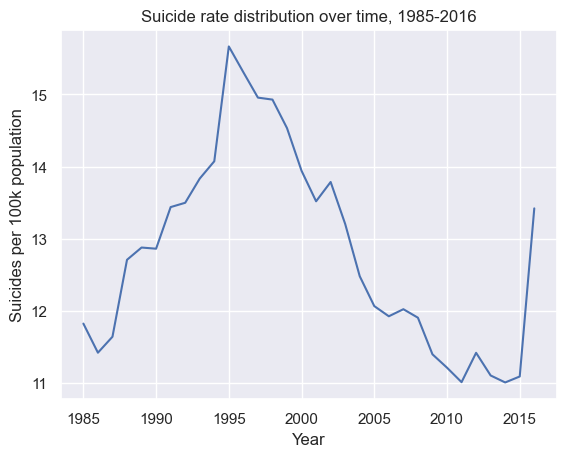

In [398]:
year_evo = raw.groupby('year')['suicides/100k pop'].mean().reset_index()
sns.set_theme()
plt.plot(year_evo['year'],year_evo['suicides/100k pop'])
plt.title("Suicide rate distribution over time, 1985-2016")
plt.xlabel('Year')
plt.ylabel('Suicides per 100k population') 
plt.show()
#The suicide rate seems to have been oscillating along time, but we do notice two peaks: one in 1995
#and another one in 2016.

We can also plot a histogram with the age group and the average rate of suicide. We first need to make an adjustment to the '5-14' value, as it does not appear correctly in the barplot.

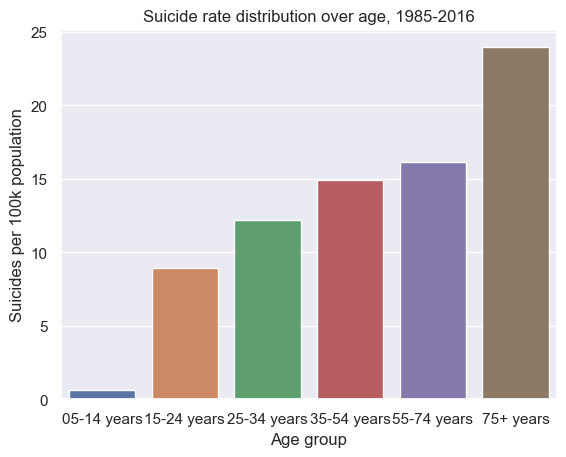

In [399]:
raw['age'] = raw['age'].apply(lambda x: '05-14 years' if x=='5-14 years' else x)
age_group_hist = raw.groupby('age')['suicides/100k pop'].mean().reset_index()
sns.set_theme()
sns.barplot(data=age_group_hist,x='age',y='suicides/100k pop')
plt.title("Suicide rate distribution over age, 1985-2016")
plt.xlabel('Age group')
plt.ylabel('Suicides per 100k population') 
plt.show()
#There is a clear trend relating age and the suicide rate. We will study this in detail later on.

It might also be interesting to have this representation separated by sex:

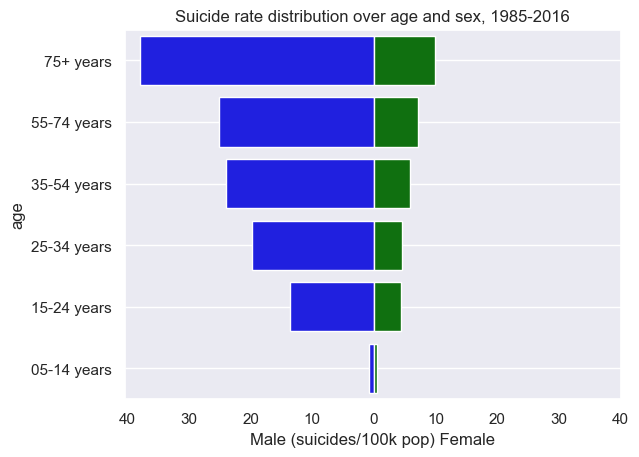

In [400]:
male_rates = raw[raw['sex']=='male'].groupby('age')['suicides/100k pop'].mean().reset_index()
fema_rates = raw[raw['sex']=='female'].groupby('age')['suicides/100k pop'].mean().reset_index()
male_rates = male_rates.rename(columns={'suicides/100k pop':'male suicides/100k pop'})
male_rates['male suicides/100k pop'] = male_rates['male suicides/100k pop']*-1.0
fema_rates = fema_rates.rename(columns={'suicides/100k pop':'female suicides/100k pop'})
joined_age_sex = male_rates.merge(right=fema_rates,on='age',how='left')
ages = ['75+ years','55-74 years','35-54 years','25-34 years','15-24 years','05-14 years']
ax1 = sns.barplot(x='male suicides/100k pop', y='age', data=joined_age_sex, order=ages, color="blue")
ax2 = sns.barplot(x='female suicides/100k pop', y='age', data=joined_age_sex, order=ages, color="green")
plt.title("Suicide rate distribution over age and sex, 1985-2016")
plt.xlabel("Male (suicides/100k pop) Female")
plt.grid()
plt.xticks(ticks=[-40,-30,-20,-10,0,10,20,30,40],
labels=['40','30','20','10','0','10','20','30','40'])
plt.show()
#we see an enormous bias here, based on sex. This will most likely be worth examining later on.

As a broader and bolder method of exploration we can just calculate and chart the correlation matrix with the raw data.

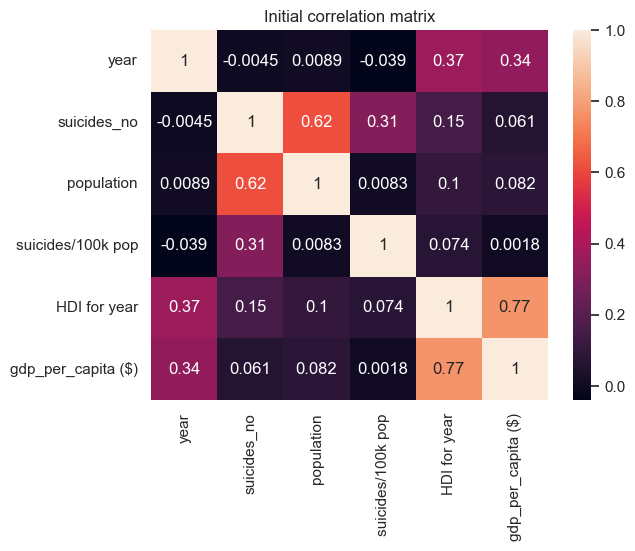

In [401]:
corr_matrix = raw.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Initial correlation matrix")
plt.show()
#we see few to no interesting values. All coefficients related to the absolute number of 
#suicides (the suicide_no) are not strongly correlated or redundant (the relative value,
#and, obviously, the population.
#we also see that variables such as the age group or the sex don't appear in this matrix.
#we'll have to clean the data in order to be able to interpret it numerically.

## Data Trimming and Cleaning
For this section we will be mainly using functions from our *clean_data.py* file.

We first trim the dataframe to only our countries of interest. This reduces the dataframe from 27820 rows to only 3452 rows.

In [402]:
eur_list = ['Russian Federation','Germany','United Kingdom','France','Italy', \
            'Spain','Ukraine','Poland','Romania','Netherlands']
raw = where_selection(df=raw,column='country',vlist=eur_list,include=True)

We will be targeting (as our dependent or *response* variable) the rate of suicides. We will now determine if any of the following columns has any null.

In [403]:
s = np.sum(raw['suicides_no'].apply(lambda x : 0 if pd.isna(x) else 1)) / len(raw['suicides_no'])
t = np.sum(raw['population'].apply(lambda x : 0 if pd.isna(x) else 1)) / len(raw['population'])
u = np.sum(raw['suicides/100k pop'].apply(lambda x : 0 if pd.isna(x) else 1)) / len(raw['suicides/100k pop'])
print(s,t,u)
#we can see that all these columns have 100% of data.

1.0 1.0 1.0


As they're all complete, we will work with the 'suicides/100k pop' column, as I believe it to better represent the relationships with all the other variables.

We should now clean up our data. We will start by removing redundant/unnecessary columns from the dataset.

In [404]:
#we will remove the following columns:
# 7: 'country-year', completely redundant with 'country' and 'year'
# 11: 'generation', as we already have 'age' and 'year'.
raw = raw.drop(columns=['country-year','generation'])

We'll now proceed to **normalize** our data, again, using methods and functions from clean_data.py.

In [405]:
#first, we make a deep copy of our dataframe, to keep the clean data untouched
wdf = raw.copy()
#we will use the lin_normalize function to normalize the following columns:
#'year','suicides_no','population','suicides/100k pop','HDI for year',
#' gdp_for_year ($) ','gdp_per_capita ($)'
cols_to_norm = ['year','suicides_no','population','suicides/100k pop', \
                'HDI for year',' gdp_for_year ($) ','gdp_per_capita ($)']
#first, unfortunately, we have to reformat a column due it's comma formatting
wdf[' gdp_for_year ($) '] = wdf[' gdp_for_year ($) '].apply( \
                            lambda x: float(x.replace(",","")))
#now we can apply the linear normalization
wdf = lin_normalize(df=wdf,columns=cols_to_norm)

For our class data, we'll just use the *class_normalize* function.

In [406]:
#regarding the sex, we can just use the class_normalize function
wdf = class_normalize(df=wdf,column='sex',mapping_order=['female','male'])

#we can do the same for the age groups
age_mapping = ['05-14 years','15-24 years','25-34 years','35-54 years',\
               '55-74 years','75+ years']
#after that we'll just normalize with the class_normalize function
wdf = class_normalize(df=wdf,column='age',mapping_order=age_mapping)

Let's see how our data looks once it's been normalized.

In [407]:
wdf.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($)
9086,France,0.0,1.0,1.0,0.068135,0.044076,0.993159,0.303846,0.136598,0.169179
9087,France,0.0,1.0,0.8,0.105784,0.184871,0.435542,0.303846,0.136598,0.169179
9088,France,0.0,1.0,0.6,0.123198,0.287022,0.333581,0.303846,0.136598,0.169179
9089,France,0.0,1.0,0.4,0.066792,0.174712,0.290059,0.303846,0.136598,0.169179
9090,France,0.0,0.0,1.0,0.029994,0.095481,0.226838,0.303846,0.136598,0.169179
9091,France,0.0,0.0,0.8,0.054526,0.219284,0.190983,0.303846,0.136598,0.169179
9092,France,0.0,1.0,0.2,0.033127,0.179499,0.140208,0.303846,0.136598,0.169179
9093,France,0.0,0.0,0.6,0.047677,0.280558,0.131965,0.303846,0.136598,0.169179
9094,France,0.0,0.0,0.4,0.020011,0.173536,0.087455,0.303846,0.136598,0.169179
9095,France,0.0,0.0,0.2,0.008819,0.173860,0.038493,0.303846,0.136598,0.169179


## Feature selection
It is now time to decide which features to keep and which ones to discard. We can judge this based on different tests and methods.

Let us plot the correlation matrix again.

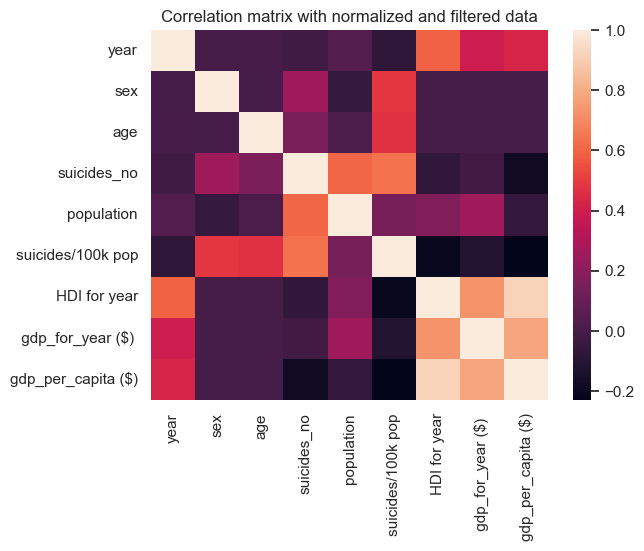

In [408]:
corr_matrix = wdf.corr()
sns.heatmap(corr_matrix, annot=False) #information crowds the plot
plt.title("Correlation matrix with normalized and filtered data")
plt.show()

We can appreciate here that both sex and age are strongly positively correlated with higher suicide rates. We also observe a decent negative correlation between the gpd per capita and the rate of suicides, same with the HDI. Let's now run a statistical t-test on the correlation matrix to see which features are meaningful.

In [409]:
cfs = corr_feature_selection(df=wdf,corr=corr_matrix,target='suicides/100k pop',threshold=0.005)
print(cfs) #TODO: fix warning!

                    suicides/100k pop    df    t-score    ts  accept
suicides_no                  0.639498  3452  48.858476  2.81    True
sex                          0.484636  3452  32.543029  2.81    True
age                          0.470863  3452  31.349765  2.81    True
gdp_per_capita ($)          -0.229213  3452 -13.831451  2.81    True
population                   0.141930  3452   8.421784  2.81    True
 gdp_for_year ($)           -0.118092  3452  -6.985189  2.81    True
HDI for year                -0.203010  1020  -6.615002  2.81    True
year                        -0.077334  3452  -4.555998  2.81    True


D:\Nero\uni\3er\MLe\KaggleCaca\kaggle-suicide-rate-study\code\generate_features.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['t-score'] = corr[target]*np.sqrt(corr['df']-2) \
D:\Nero\uni\3er\MLe\KaggleCaca\kaggle-suicide-rate-study\code\generate_features.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['ts'] = ts


Due to the high amount of data (thus, degrees of freedom) that the dataset posesses, the tscore is high enough to be significantly different than zero. Even so, we can clearly see that 'population', ' gdp_for_year ($) ' and 'year' don't even reach a correlation coefficient of 0.2, which is a sign strong enough by itself to consider discarding these features.

Let's see now how they test against a Lasso feature selection test. Unfortunately we'll have to skip the Country and the HDI score, as they contain non-numerical values (it's obvious for the Country, but the HDI has a high rate of NaNs).

In [410]:
twdf = wdf.drop(columns=['country','HDI for year'])
from generate_features import lasso_feature_selection
features = lasso_feature_selection(df=twdf, target='suicides/100k pop', alph=np.arange(0.005,1,0.005))
features

{'model__alpha': 0.005}
Accepted: ['sex' 'age' 'suicides_no' 'population' 'gdp_per_capita ($)']
Discarded: ['year' ' gdp_for_year ($) ']


array(['sex', 'age', 'suicides_no', 'population', 'gdp_per_capita ($)'],
      dtype=object)

We can now try with other methods from scikitlearn. Let's start by removing low-variance features.

In [411]:
from sklearn.feature_selection import VarianceThreshold
X = wdf.drop(columns=['suicides/100k pop','country'])
vt = 0.75
selector = VarianceThreshold(threshold=(vt*(1-vt)))
selector.fit_transform(X)
print(X.columns) 

Index(['year', 'sex', 'age', 'suicides_no', 'population', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)'],
      dtype='object')


It seems like all columns have enough variance to be considered.

We can also try an RFE feature selection.

In [412]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X = wdf.drop(columns=['country','HDI for year','suicides/100k pop'])
y = wdf['suicides/100k pop']
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selected = [X.columns[i] for i in range(len(X.columns)) if selector.support_[i]]
discard = [X.columns[i] for i in range(len(X.columns)) if not selector.support_[i]]
print("Selected",selected)
print("Discarded",discard)

Selected ['sex', 'age', 'suicides_no', 'population', 'gdp_per_capita ($)']
Discarded ['year', ' gdp_for_year ($) ']


But what about the HDI? We need to see how "incomplete" is the column, and based on that, decide whether to discard it or not.

<AxesSubplot:xlabel='country', ylabel='no-null ratio'>

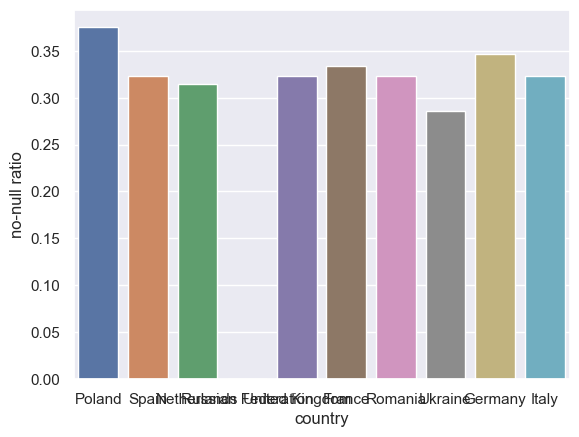

In [413]:
conts = list(set(list(wdf['country'])))
nonan = []
for c in conts:
    parted = wdf[wdf['country']==c]['HDI for year']
    parted = parted.apply(lambda x: 1 if pd.notna(x) else 0)
    nonan.append(sum(parted)/len(parted))
tdf = pd.DataFrame([conts,nonan]).transpose()
tdf = tdf.rename(columns={0:'country',1:'no-null ratio'})
sns.barplot(data=tdf,x='country',y='no-null ratio')

As we've been able to see, the no-null ratio is not even reaching half of the data. Let's see if it's at least consistently distributed along time.

{1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016}


<AxesSubplot:xlabel='year', ylabel='no-null ratio'>

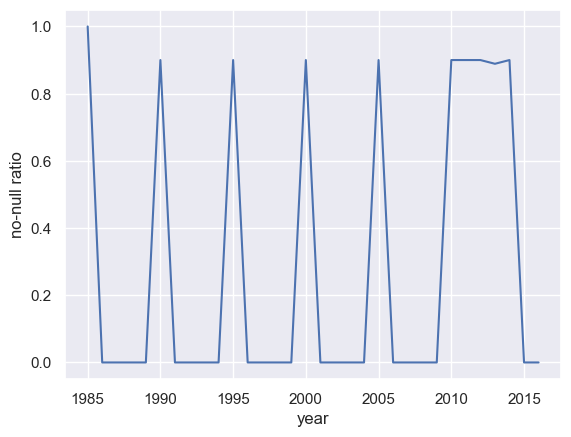

In [414]:
years = set(raw['year'])
nonan = []
for c in years:
    parted = raw[raw['year']==c]['HDI for year']
    parted = parted.apply(lambda x: 1 if pd.notna(x) else 0)
    nonan.append(sum(parted)/len(parted))
print(years)
tdf = pd.DataFrame([years,nonan]).transpose()
tdf = tdf.rename(columns={0:'year',1:'no-null ratio'})
sns.lineplot(data=tdf,x='year',y='no-null ratio')

It looks like the HDI is calculated every five years, but again we have some countries without a single record for this variable. We will not be taking it into consideration for our model.

## Model learning
For the model training section, we'll be starting off with a simple (multi) linear model.

#### Multi Linear Model

In [415]:
#we first need to import the necessary functions
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump, load

After going through the feature selection, we will be using the following variables in our dataset:
 - Target / Response variable: suicide rate over 100k pop
 - Independent variables: Year, Sex, Age, GDP per capita and Population. Country is also an independent variable, but we won't be using it directly.

In [416]:
wdf = wdf.drop(columns=['suicides_no','HDI for year',' gdp_for_year ($) '])
X = wdf.drop(columns = ['suicides/100k pop','country'])
Y = wdf['suicides/100k pop']

We now split our dataset into train and test.

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

And then we simply create and fit our model with the corresponding data.

In [418]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

Finally we just need to test our model's performance:

In [419]:
predictions = model.predict(X_test)
print("MSE : ", mean_squared_error(y_test, predictions))
print("MAE : ", mean_absolute_error(y_test, predictions))
r_squared = model.score(X_test, y_test)
print("R2 : ", r_squared)

MSE :  0.011819609901396287
MAE :  0.07602417165043578
R2 :  0.5433106176643289


In [420]:
#save the coefficients:
print(model.coef_)
dump(model, '../models/linear_regression.joblib') 

[ 0.00789915  0.1606669   0.22630846  0.14246938 -0.13729999]


['../models/linear_regression.joblib']

#### Ridge - Tikhonov regularization
This method tries to minimize the error function $||y - Xw||^2_2 + \alpha * ||w||^2_2$, where $y$ is our target vector, $X$ our independent variable matrix, and $w$ the weights or coefficients. We also use an adjustment coefficient $\alpha$ to better tune the results of the method.

In [421]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [422]:
predictions = model.predict(X_test)
print("MSE : ", mean_squared_error(y_test, predictions))
print("MAE : ", mean_absolute_error(y_test, predictions))
r_squared = model.score(X_test, y_test)
print("R2 : ", r_squared)

MSE :  0.01230648498766841
MAE :  0.07831081029070995
R2 :  0.5425608888893978


Let's now try to optimize this result by tweaking the alpha.

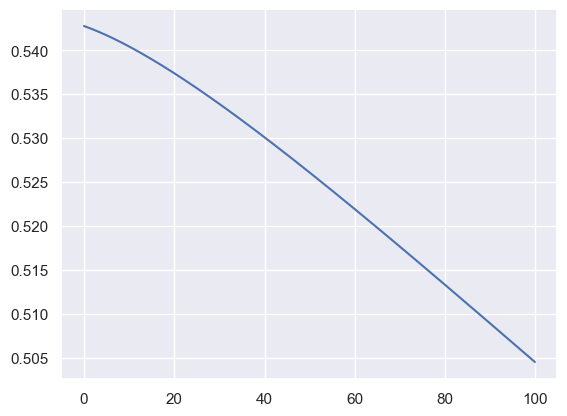

In [423]:
alphas = np.arange(0.001,100,0.1)
rs = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    r_squared = model.score(X_test, y_test)
    rs.append(r_squared)
plt.plot(alphas,rs)

We'll simply get alpha=1, as it seems to be good enough.

In [424]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
print("R^2 :", model.score(X_test, y_test))
print(X_train.columns)
print(model.coef_)
dump(model, '../models/ridge_regularization.joblib') 

R^2 : 0.5425608888893978
Index(['year', 'sex', 'age', 'population', 'gdp_per_capita ($)'], dtype='object')
[ 0.00708732  0.15979382  0.22463193  0.13342584 -0.14052406]


['../models/ridge_regularization.joblib']

#### Lasso Regression
The Lasso uses the same methodology as the Elastic Net without the penalty. To be more exact, its cost function is the following: $(1 / (2 * n_{samples})) * ||y - Xw||^2_2 + alpha * ||w||_1$, the variables being the same as in the Ridge - Tikhonov model.

In [425]:
from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
model = linear_model.Lasso(alpha=0.001)
model.fit(X_train, y_train)
print("R^2",model.score(X_test, y_test))
print(list(X_train.columns))
print(model.coef_)
print(model.intercept_)

R^2 0.49660817081103803
['year', 'sex', 'age', 'population', 'gdp_per_capita ($)']
[-0.          0.15827828  0.21759691  0.13757087 -0.1260671 ]
-0.03879083017328605


Let's plot the evolution of our R^2 as we tweak the alpha. We'll also plot the coefficients each feature gets along the alpha.

In [426]:
coefs = []
rsqua = []
alphs = np.arange(0.06,0.001,-0.0005)
for alpha in alphs:
    model = linear_model.Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)
    rsqua.append(model.score(X_test, y_test))
#transpose coefficients
coefs = [[row[i] for row in coefs] for i in range(len(coefs[0]))]

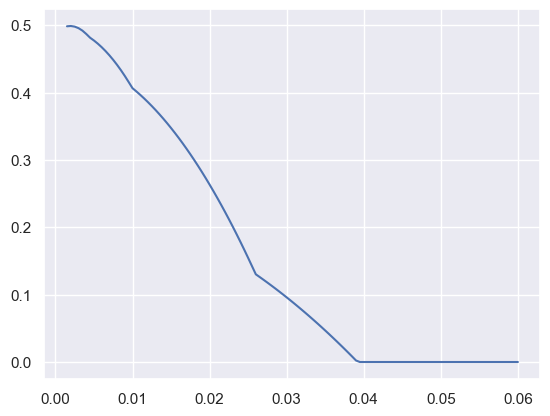

In [427]:
plt.plot(alphs,rsqua)
plt.show()

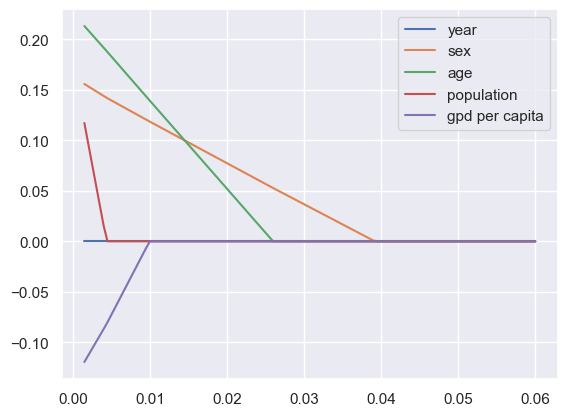

In [428]:
plt.plot(alphs,coefs[0],label='year')
plt.plot(alphs,coefs[1],label='sex')
plt.plot(alphs,coefs[2],label='age')
plt.plot(alphs,coefs[3],label='population')
plt.plot(alphs,coefs[4],label='gpd per capita')
plt.legend()
plt.show()

In [429]:
#find the best alpha:
myi = np.argmax(rsqua)
print("best R^2:", rsqua[myi])
best_alpha = alphs[myi]
#transpose again
coefs = [[row[i] for row in coefs] for i in range(len(coefs[0]))]
best_coefs = coefs[myi]
print(best_coefs)
#retrain and save the model
model = linear_model.Lasso(alpha=best_alpha)
model.fit(X_train, y_train)
dump(model, '../models/lasso_model.joblib') 

best R^2: 0.49880344735326354
[-0.0, 0.15352765565471993, 0.2089992257560024, 0.09689411707526382, -0.11300167664147732]


['../models/lasso_model.joblib']

As we can see, the R^2 isn't extremely high, but it's consistent enough to make some analysis on it. We can see that the year (by the Lasso model) doesn't have much importance, but the other variables do:
 - Seems like the Sex influences *positively* the suicide tendency. As 1 is Male and 0 Female, this indicates that males tend to have higher suicide rates.
 - Same thing happens with age, with a considerably stronger positive coefficient. As people grow old, their suicide rate tends to increase.
 - Population also plays a role at the suicide rate, altough not as important. Seems like highly populated countries have a slighly higher suicide rate than others.
 - Finally, we observe that the GPD per capita *decreases* with suicide rates. People with higher income tend to commit suicide less often, or at least, those variables seem to be correlated.

### Country-isolated analysis
Right now, our best R^2 stands at almost 0.55 achieved by both the Linear Regression and the Ridge method. But we've been looking at data at a global level. What if we study each country separately and then aggregate the results? We'll do this with the Ridge regression and see what happens.

In [430]:
rsqua = []
conts = []
coefs = []
for country in list(set(list(wdf['country']))):
    Xi = wdf[wdf['country']==country]
    X = Xi.drop(columns = ['country','suicides/100k pop'])
    y = Xi['suicides/100k pop']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    r_squared = model.score(X_test, y_test)
    conts.append(country)
    rsqua.append(r_squared)
    coefs.append(model.coef_)
    dump(model, '../models/'+str(country)+'_model.joblib') 
print(conts)
print(rsqua)
print("Average R^2:",np.mean(rsqua),"STD:",np.std(rsqua))
coefs = [[row[i] for row in coefs] for i in range(len(coefs[0]))]

['Poland', 'Spain', 'Netherlands', 'Russian Federation', 'United Kingdom', 'France', 'Romania', 'Ukraine', 'Germany', 'Italy']
[0.7886723997950136, 0.7438346665846902, 0.7508555341834398, 0.772332885841028, 0.7028287760089308, 0.7065504702021868, 0.8252536632522188, 0.7890381626344285, 0.7746567638758937, 0.7149459734223081]
Average R^2: 0.7568969295800139 STD: 0.038333011838096225


As we can see, and even without individual alpha optimization, results look way better now. We bumped our R^2 from around 0.54 up to 0.76, which is a sign of good correlation without a worry about overfittingness. Also our STD is just about 0.04, which seems just about right.

In [431]:
my_res = pd.DataFrame(conts)
X.columns
my_res['year'] = coefs[0]
my_res['sex'] = coefs[1]
my_res['age'] = coefs[2]
my_res['population'] = coefs[3]
my_res['gdp_per_capita ($)'] = coefs[4]
my_res['R^2'] = rsqua
my_res

,0,year,sex,age,population,gdp_per_capita ($),R^2
0,Poland,-0.002440,0.176148,0.151717,0.195946,-0.023071,0.788672
1,Spain,-0.014012,0.088560,0.172750,-0.195599,0.006634,0.743835
2,Netherlands,-0.011367,0.069131,0.140677,0.012142,-0.022041,0.750856
3,Russian Federation,-0.092378,0.374484,0.376224,-0.004058,-0.288589,0.772333
4,United Kingdom,-0.013492,0.065973,0.068083,0.077482,-0.015320,0.702829
5,France,-0.097518,0.178129,0.379829,-0.252253,0.016525,0.706550
6,Romania,-0.011142,0.129210,0.164313,0.069367,-0.029459,0.825254
7,Ukraine,-0.077539,0.279382,0.372399,-0.052783,-0.070007,0.789038
8,Germany,-0.087691,0.129393,0.296408,-0.234503,0.008782,0.774657
9,Italy,-0.030977,0.075737,0.166784,-0.167366,0.005867,0.714946


## Conclusion
In conclusion, the method that performed the best is, by far, the country-isolated Regression. After studying the individual correlations per country, we've seen that the socioeconomic factors are indeed related to the suicide rates, but differently for each country. This is why separating the dataset country-wise bumped up our results that much.

Comparing it to similar studies, it has also been [observed](https://www.kaggle.com/code/chingchunyeh/suicide-rates-overview-1985-to-2016) that indeed socioeconomic factors affect differently each country, and that our most significantly correlated variables (sex and age) are also the ones being observed by other users.
Sadly, no other user got into the same depth when it comes to feature selection or model evaluation, so there is no way to compare our R^2 score to the community obtained results. Even so, personally, our R^2 is good enough to render the results meaningful, and I think the approach taken is rigorous enough for the scope of the study.

## Further ideas / investigation
To further understand how the socioeconomic factors affect each country's suicide rate, it would be interesting to study each and every one of them individually along some historical data (economic crisis, pandemics, wars, etc). That would contextualize our data in a way that would allow us (even with low-decent R^2 values) to make stronger assumptions and learn more concrete insights about this topic